<a href="https://colab.research.google.com/github/mini3713/mini3713/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%2B%EB%94%A5%EB%9F%AC%EB%8B%9D/XGBoost_04_From_Gradient_Boosting_to_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**4 그레이디언트 부스팅에서 XGBoost까지**
=======================
그레이디언트 부스팅의 작동방식을 이해하고 실습

4.1 배깅에서 부스팅까지
====================
> * 랜덤포레스트와 다르게 **부스팅**은 개별트리의 실수로부터 학습 
> * 이전 트리의 오차를 기반으로 새로운 트리를 훈련

> ### 에이다부스트 소개
> * 초기 부스팅 모델이며, 새로운 트리가 이전 트리의 오차를 기반으로 가중치를 조정 
> * 오류 샘플의 가중치를 높여 잘못된 예측에 더 많은 주의를 기울임 
> * **약한 학습기**인 기반 모델을 수백번의 반복을 통해 **강력한 학습기**로 만들어줌 
>  * 기반모델이 너무 강하면 학습과정이 제한되어 부스팅 모델의 전략을 약화시킴 

> ### 그레이디언트 부스팅의 특징
> * 에이다부스트와는 다르게 이전 트리의 예측 오차를 기반으로 **완전히 새로운 트리**를 훈련
> * 새로운 트리는 올바르게 예측된 값에는 영향을 받지 않음 
> * 오차를 계산하기 위해 예측과 실제값 사이의 차이인 **잔차**(residual)를 활용
> * 그레이디언트 부스팅은 각 트리 예측 값을 더해서 모델 평가에 사용 

4.2 그레이디언트 부스팅 작동 방식
====================

> ### 잔차
> * 통계학에서는 일반적으로 선형 회귀모델이 데이터에 얼마나 잘 맞는지 평가하기 위해 사용됨 
> * 선형회귀의 목적은 잔차의 제곱을 최소화하는 것 
> * 그레이디언트 부스팅 알고리즘을 직접 구현해보기 위해 각 트리의 잔차를 계산하고 이 잔차에 새로운 모델을 훈련

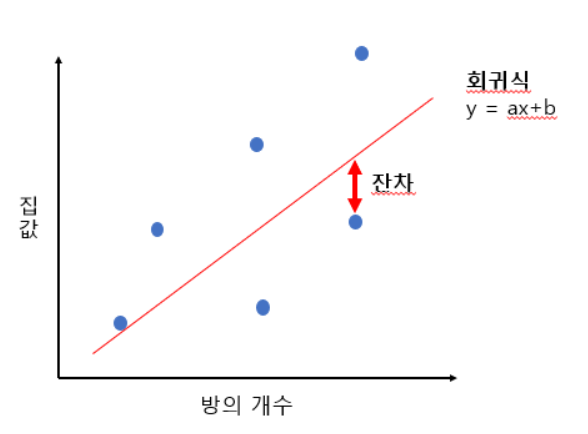

출처 : https://blog.naver.com/PostView.nhn?blogId=winddori2002&logNo=221676654945

> ### 결정트리로 그레이디언트 부스팅 모델 만들기

In [2]:
# 자전거 대여 데이터셋 활용
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [3]:
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [5]:
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:, -1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

In [6]:
from sklearn.tree import DecisionTreeRegressor
tree_1 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [7]:
# 훈련세트에 대한 예측을 생성
# 잔차를 계산하기 위해서, 훈련단계에서 예측과 타깃을 비교해야 함 
# 모델의 테스트 단계는 모든 트리를 구성한 후 마지막 순서 
y_train_pred = tree_1.predict(X_train)
# 잔차 계산
y2_train = y_train - y_train_pred

In [8]:
# 잔차를 기반으로 새로운 트리를 훈련 
tree_2 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [9]:
# 앞단계를 반복
y2_train_pred = tree_2.predict(X_train)
y3_train = y2_train - y2_train_pred
tree_3 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_3.fit(X_train, y3_train)
# 강력한 학습기를 만들기 위해, 이 과정이 수십, 수백, 수천개의 트리까지 계속될 수 있음 

DecisionTreeRegressor(max_depth=2, random_state=2)

In [11]:
y1_pred = tree_1.predict(X_test)
y2_pred = tree_2.predict(X_test)
y3_pred = tree_3.predict(X_test)
# 예측을 합해준다
# 잔차는 음수값도 존재하기 때문에 예측값이 음수값이 될 수 있다
# 따라서 예측을 모두 더하면 타깃에 더 가까운 결과를 만들게 된다 
y_pred = y1_pred + y2_pred + y3_pred
# 평균 제곱근 오차(RMSE)를 계산
from sklearn.metrics import mean_squared_error as MSE
MSE(y_test, y_pred)**0.5

911.0479538776444

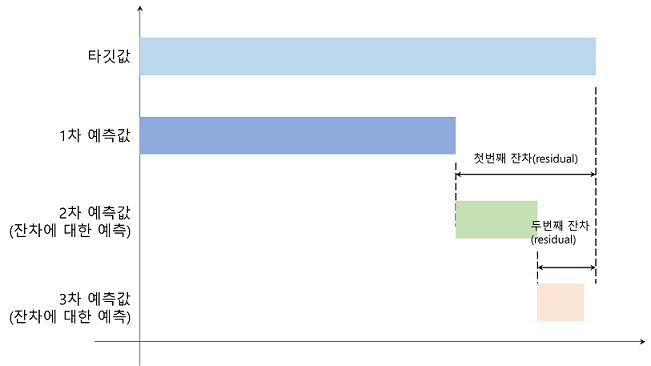

> ### 사이킷런으로 그레이디언트 부스팅 모델 만들기

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=2, learning_rate=1.0)

In [19]:
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

911.0479538776439

In [20]:
# 트리 개수를 30개로 증가
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=30, random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

857.1072323426944

In [21]:
# 트리 개수를 300개로 증가
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

936.3617413678853

In [22]:
# learning_rate 매개변수를 제거하면?
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

653.7456840231495